In [1]:
# importing cell
import numpy as np
import numpy.random as npr
npr.seed(5555)
import matplotlib.pyplot as plt
from sklearn import manifold

# LCPB 21-22 Exercise 4, data visualization and clustering

## Exercise 4A

Consider data generated during the lesson.



In [2]:
x = np.loadtxt('DATA/x_3d.dat') # shaped like (1000,3) 
y = np.loadtxt('DATA/y_3d.dat') # shaped like (1000,)

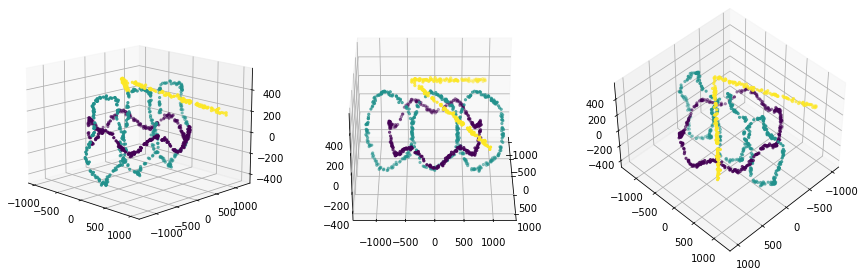

In [3]:
fig = plt.figure(figsize=(15, 5))
for i in range(3):
    ax = fig.add_subplot(1,3,i+1,projection='3d')
    ax.scatter(x[:,0], x[:,1],x[:,2], s=5, c=y, depthshade=True, cmap='viridis')
    ax.view_init(15+15*i, 45*(i-1))
plt.draw()

### 1) The role of dimensions

In each sample increase the number of dimensions from 3 to L>3, by introducing L-3
additional dimensions with noisy inputs. Study how visualization with t-SNE and clustering
with DBSCAN are affected by this increase in dimensionality.
To mix the information between all L dimensions while preserving the distances between
points, one can also perform some rotation of data with orthonormal random matrices M in
O(L): x → M.x

In [4]:
# dimension increasing

N = x.shape[0]
L = 6
noise_scale = 25

x_aug = np.hstack((x,npr.normal(loc=0,scale=noise_scale,size=(N,L-3))))

from scipy.stats import special_ortho_group
Mrot = special_ortho_group.rvs(L) # routine from scipy that generates a random orthogonal matrix with det=1 in L dimensions
print(Mrot.shape)
print("Determinant: ",np.linalg.det(Mrot))


(6, 6)
Determinant:  1.0000000000000007


In [5]:
# apply the rotation
x_aug = (Mrot @ x_aug.T).T

#### t-SNE
We will now apply t-SNE to the augmented and rotated dataset, trying to get back to the original 3 dimensions.

In [15]:
n_components = 3
perplexity = 30 
tsne=manifold.TSNE(n_components=n_components,perplexity=perplexity,early_exaggeration=12.0,learning_rate=200.0)

x_tsne=tsne.fit_transform(x_aug)

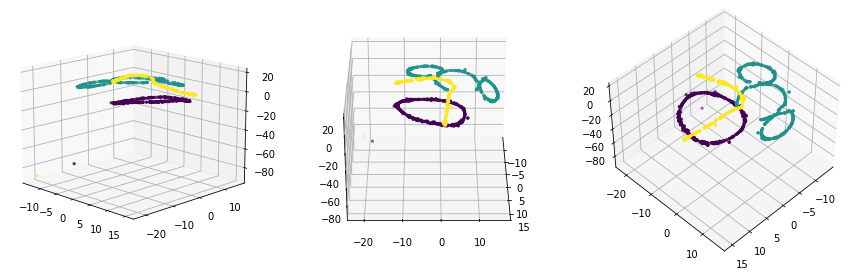

In [16]:
fig = plt.figure(figsize=(15, 5))
for i in range(3):
    ax = fig.add_subplot(1,3,i+1,projection='3d')
    ax.scatter(x_tsne[:,0], x_tsne[:,1],x_tsne[:,2], s=5, c=y, depthshade=True, cmap='viridis')
    ax.view_init(15+15*i, 45*(i-1))
plt.draw()

#### Comments on the performance of t-SNE over our dataset

Even when augmentating the dataset with 3 additional dimensions composed of gaussian noise and rotating it in the $L$-dimensional space, t-SNE manages to retrieve partial information about the original underlying structure of the dataset: points that were grouped together in a circle-like structure retain such structure although simplified (apparently the wavey component of it contributes the same to the entropy as a simpler one); points that were distributed along some sort of snapped line still present such structure with a breaking angle in the middle, and the more complicated rings pattern almost makes it back as a whole.


### 2) The role of “perplexity” in t-SNE

Provide your explanation on the patterns observed by varying the perplexity of t-SNE.
Do they vary if t-SNE is initialized by using principal component analysis (init=’pca’)?


### 3) Tuning of “eps” and “minPts” in DBSCAN algorithm for clustering

The grid with several values of “eps” and “minPts” shows that the normalized mutual
information (NMI) between true and predicted clusters is varying. Is there a correlation
between these two parameters in providing a high NMI? Is there a way of guessing good
values for “eps” and “minPts”.
Note: in the lesson we have looked at the typical distance between a point and its closest
neighbor, but this does not say what is the typical distance from the 2nd, 3rd , …, “minPts”-
neighbor.
Furthermore, a possibility to consider is the plotting of ranked distances.

### 4) VERY VERY OPTIONAL: t-SNE for clustering?

We know that t-SNE is stochastic and may converge to a different result if the random seed
is varied. Moreover, visibly the result depends also on perplexity. Possibly, by checking
which points are more likely to stay close to each other in different runs of t-SNE, one is
able to assess the connectivity of the points in the original space, with implications for their
clustering.